In [ ]:
from keras import Model, Input
from keras.layers import Convolution2D, Convolution2DTranspose, MaxPool2D, UpSampling2D
import glob2
from PIL import Image
from numpy import asarray
import numpy as np
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.25)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/CASIA_WebFace/800_TrainAndTest',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='input')

print(training_set[0][0].shape)
print(training_set[0][1].shape)

val_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Datasets/CASIA_WebFace/800_TrainAndTest',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='input',
                                            subset='validation')

Found 975 images belonging to 1 classes.
(32, 224, 224, 3)
(32, 224, 224, 3)
Found 0 images belonging to 1 classes.


In [ ]:

#from keras.callbacks import TensorBoard

# Remove this if you have GPU support
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

ae_epochs = 100
latent_code_size = 128
batch_size = 128
num_epochs = 200
learning_rate = 1e-3
#original_image_path = "/content/drive/MyDrive/Datasets/CASIA_WebFace/0000045"
#image_list = glob2.glob(original_image_path + '\\*.jpg')
#print(len(image_list))

class AutoEncoder():
    def __init__(self, latent_code_size, size = 32):
        self.conv1 = Convolution2D(size, (3, 3), padding='same', activation='relu')
        self.conv2 = Convolution2D(size*2, (3, 3), padding='same', activation='relu')
        self.conv3 = Convolution2D(size*4, (3, 3), padding='same', activation='relu')
        self.conv4 = Convolution2D(latent_code_size, (3, 3), padding='same', activation='relu')

        self.trans1 = Convolution2D(size*4, (3, 3), padding='same', activation='relu')
        self.trans2 = Convolution2D(size*2, (3, 3), padding='same', activation='relu')
        self.trans3 = Convolution2D(size, (3, 3), padding='same', activation='relu')
        self.trans4 = Convolution2D(3, (3, 3), padding='same', activation='relu')
        self.mp = MaxPool2D((2, 2), padding='same')
        self.up = UpSampling2D((2,2))

    def encoder(self, x):
        x = self.conv1(x) # [?, 32, 224, 224]
        x = self.mp(x) # [?, 32, 112, 112] #, ind1
        x = self.conv2(x) # [?, 64, 112, 112]
        x = self.mp(x) # [?, 64, 56, 56]
        x = self.conv3(x) # [?, 128, 56, 56]
        x = self.mp(x) # [?, 128, 28, 28]
        x = self.conv4(x) # [?, 32, 28, 28]
        return x

    def decoder(self, x):
        x = self.trans1(x) # [128, 128, 28, 28]
        x = self.up(x) # [128, 128, 56, 56]
        x = self.trans2(x) # [128, 128, 56, 56]
        x = self.up(x) # [128, 128, 112, 112]
        x = self.trans3(x) # [128, 128, 112, 112]
        x = self.up(x) # [128, 128, 224, 224]
        x = self.trans4(x) # [128, 128, 224, 224]
        return x

input_img = Input(shape=(224, 224, 3))
auto_encoder = AutoEncoder(latent_code_size)
encoder= auto_encoder.encoder(input_img)
decoder = auto_encoder.decoder(encoder)
autoencoder = Model( input_img, decoder)
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#autoencoder.summary()
checkpoint = ModelCheckpoint("/content/drive/MyDrive/GAN/128/best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=10)
history = autoencoder.fit(training_set,
                epochs=ae_epochs,
                shuffle=True,
                batch_size =32,
                validation_data=val_set,
                callbacks=[checkpoint])

autoencoder.save('/content/drive/MyDrive/GAN/128')
clssf = autoencoder.to_json()
with open("/content/drive/MyDrive/GAN/128/100Ep128LC.json", "w") as json_file:
    json_file.write(clssf)
autoencoder.save_weights("/content/drive/MyDrive/GAN/128/100Ep128LC.h5")

Epoch 1/100
31/31 [==============================] - 300s 9s/step - loss: 1.5902 - accuracy: 0.5428
Epoch 2/100
31/31 [==============================] - 283s 9s/step - loss: 0.5351 - accuracy: 0.8141
Epoch 3/100
31/31 [==============================] - 281s 9s/step - loss: 0.5172 - accuracy: 0.8053
Epoch 4/100
31/31 [==============================] - 284s 9s/step - loss: 0.5098 - accuracy: 0.7983
Epoch 5/100
31/31 [==============================] - 282s 9s/step - loss: 0.5074 - accuracy: 0.8194
Epoch 6/100
31/31 [==============================] - 281s 9s/step - loss: 0.5008 - accuracy: 0.8229
Epoch 7/100
31/31 [==============================] - 281s 9s/step - loss: 0.5096 - accuracy: 0.8259
Epoch 8/100
31/31 [==============================] - 285s 9s/step - loss: 0.5068 - accuracy: 0.8305
Epoch 9/100
31/31 [==============================] - 281s 9s/step - loss: 0.5052 - accuracy: 0.8127
Epoch 10/100
31/31 [==============================] - 281s 9s/step - loss: 0.5026 - accuracy: 0.8237

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GAN/128/assets


In [ ]:
autoencoder.save('/content/drive/MyDrive/GAN/128')
clssf = autoencoder.to_json()
with open("/content/drive/MyDrive/GAN/128/100Ep128LC.json", "w") as json_file:
    json_file.write(clssf)
autoencoder.save_weights("/content/drive/MyDrive/GAN/128/100Ep128LC.h5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/GAN/assets


In [ ]:
history.history['loss']

NameError: ignored

dict_keys(['loss'])


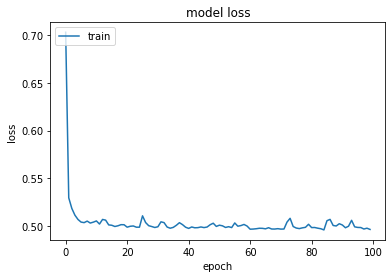

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()
# "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Datasets/CASIA_WebFace/800_TrainAndTest')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
